# Regression from Scratch

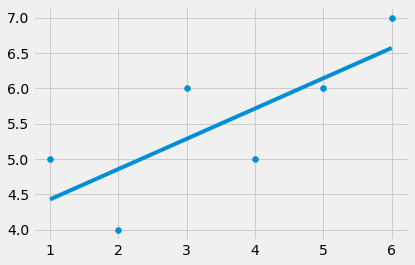

In [26]:
from statistics import mean 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')

x= [1,2,3,4,5,6]
y= [5,4,6,5,6,7]

def find_slope(x,y):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    numerator = (mean(x) * mean(y)) - mean(x * y)
    denominator = ( (mean(x)**2) - mean(x**2) )
    slope = numerator / denominator
    inter = mean(y) - (mean(x) * slope)
    return slope, inter

def run_LR_prediction(input):
    m,b = find_slope(x,y)       
    return (input*m) + b

LR_line = [run_LR_prediction(i) for i in x]



plt.scatter(x, y)
plt.plot(x, LR_line)

# Regression Analysis on Equity data

In [5]:

from keys import QUANDL_API_KEY
import pandas as pd 
import quandl
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
from matplotlib import style
import datetime
import pickle

style.use('ggplot')

df = quandl.get('WIKI/GOOGL', api_key = QUANDL_API_KEY)
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCG'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close']-df['Adj. Open']) / df['Adj. Open'] * 100.0
df=df[['Adj. Close','HL_PCG','PCT_change','Adj. Volume']]



# fetch data

In [6]:
df = quandl.get('WIKI/GOOGL', api_key = QUANDL_API_KEY)
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCG'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close']-df['Adj. Open']) / df['Adj. Open'] * 100.0
df=df[['Adj. Close','HL_PCG','PCT_change','Adj. Volume']]

# construct the datafram

In [7]:

df.fillna(-99999, inplace=True)#fill it as an outliar instead of just dropping it 
forecast_out = int(math.ceil(0.01*len(df)))#using 10 days data to predict it 
df['label'] = df['Adj. Close'].shift(-forecast_out)#shifting forward the number of columns

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])



# Train the data and pickl it


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

classifier_LR = LinearRegression()
classifier_SVR = svm.SVR()

classifier_LR.fit(X_train, y_train)

# with open('equity_LR.pickle', 'wb') as f:
#     pickle.dump(classifier_LR, f)

pickle_open = open('equity_LR.pickle', 'rb')

classifier_LR = pickle.load(pickle_open)

confidence_LR = classifier_LR.score(X_test, y_test)
forecasted = classifier_LR.predict(X_lately)

# classifier_SVR.fit(X_train, y_train)
# confidence_SVR = classifier_SVR.score(X_test, y_test)


# print(df.iloc[[0]])
print(confidence_LR)

0.9774164387215207


# add date column to the dataframe


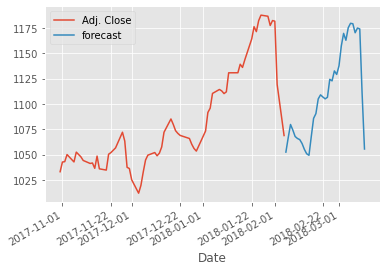

In [9]:
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecasted:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df.iloc[-100:]['Adj. Close'].plot()
df.iloc[-100:]['forecast'].plot()
plt.legend(loc=2)
plt.show()

# R Squared